https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.2


In [5]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [70]:
df_raw = pd.read_csv('Data/2010_animation_ratings.csv')
df_raw.head()

,userId,movieId,rating,timestamp,title,Group_Number
0,177,78637,2.5,1435837464,Shrek Forever After (a.k.a. Shrek: The Final C...,3
1,514,76093,4.0,1533872585,How to Train Your Dragon (2010),1
2,252,78499,5.0,1498284330,Toy Story 3 (2010),2
3,567,76093,2.5,1525287804,How to Train Your Dragon (2010),1
4,586,81847,4.5,1529903135,Tangled (2010),8


In [71]:
df = df_raw.drop(columns=['userId', 'movieId', 'timestamp'])

print("The dataset contains {} unique movie titles.".format(df['title'].nunique()))

df.head()

The dataset contains 8 unique movie titles.


,rating,title,Group_Number
0,2.5,Shrek Forever After (a.k.a. Shrek: The Final C...,3
1,4.0,How to Train Your Dragon (2010),1
2,5.0,Toy Story 3 (2010),2
3,2.5,How to Train Your Dragon (2010),1
4,4.5,Tangled (2010),8


In [72]:
# Manually create a dictionary mapping full titles to short titles
title_to_short = {
    'Shrek Forever After (a.k.a. Shrek: The Final Chapter) (2010)': 'Shrek',
    'How to Train Your Dragon (2010)': 'Dragon',
    'Toy Story 3 (2010)': 'Toy_Story',
    'Tangled (2010)': 'Tangled',
    'Despicable Me (2010)': 'Despicable_me',
    'Legend of the Guardians: The Owls of Ga\'Hoole (2010)': 'Guardians',
    'Megamind (2010)': 'Megamind',
    'Batman: Under the Red Hood (2010)': 'Batman'
}

# Create a new column 'short_title' by mapping the 'title' column through the dictionary
df['title'] = df['title'].map(title_to_short)

titles = df['title'].unique()

title_to_ratings = {title: df[df['title'] == title]['rating'].values for title in titles}

# Display the DataFrame to verify the new column
df.head()

,rating,title,Group_Number
0,2.5,Shrek,3
1,4.0,Dragon,1
2,5.0,Toy_Story,2
3,2.5,Dragon,1
4,4.5,Tangled,8


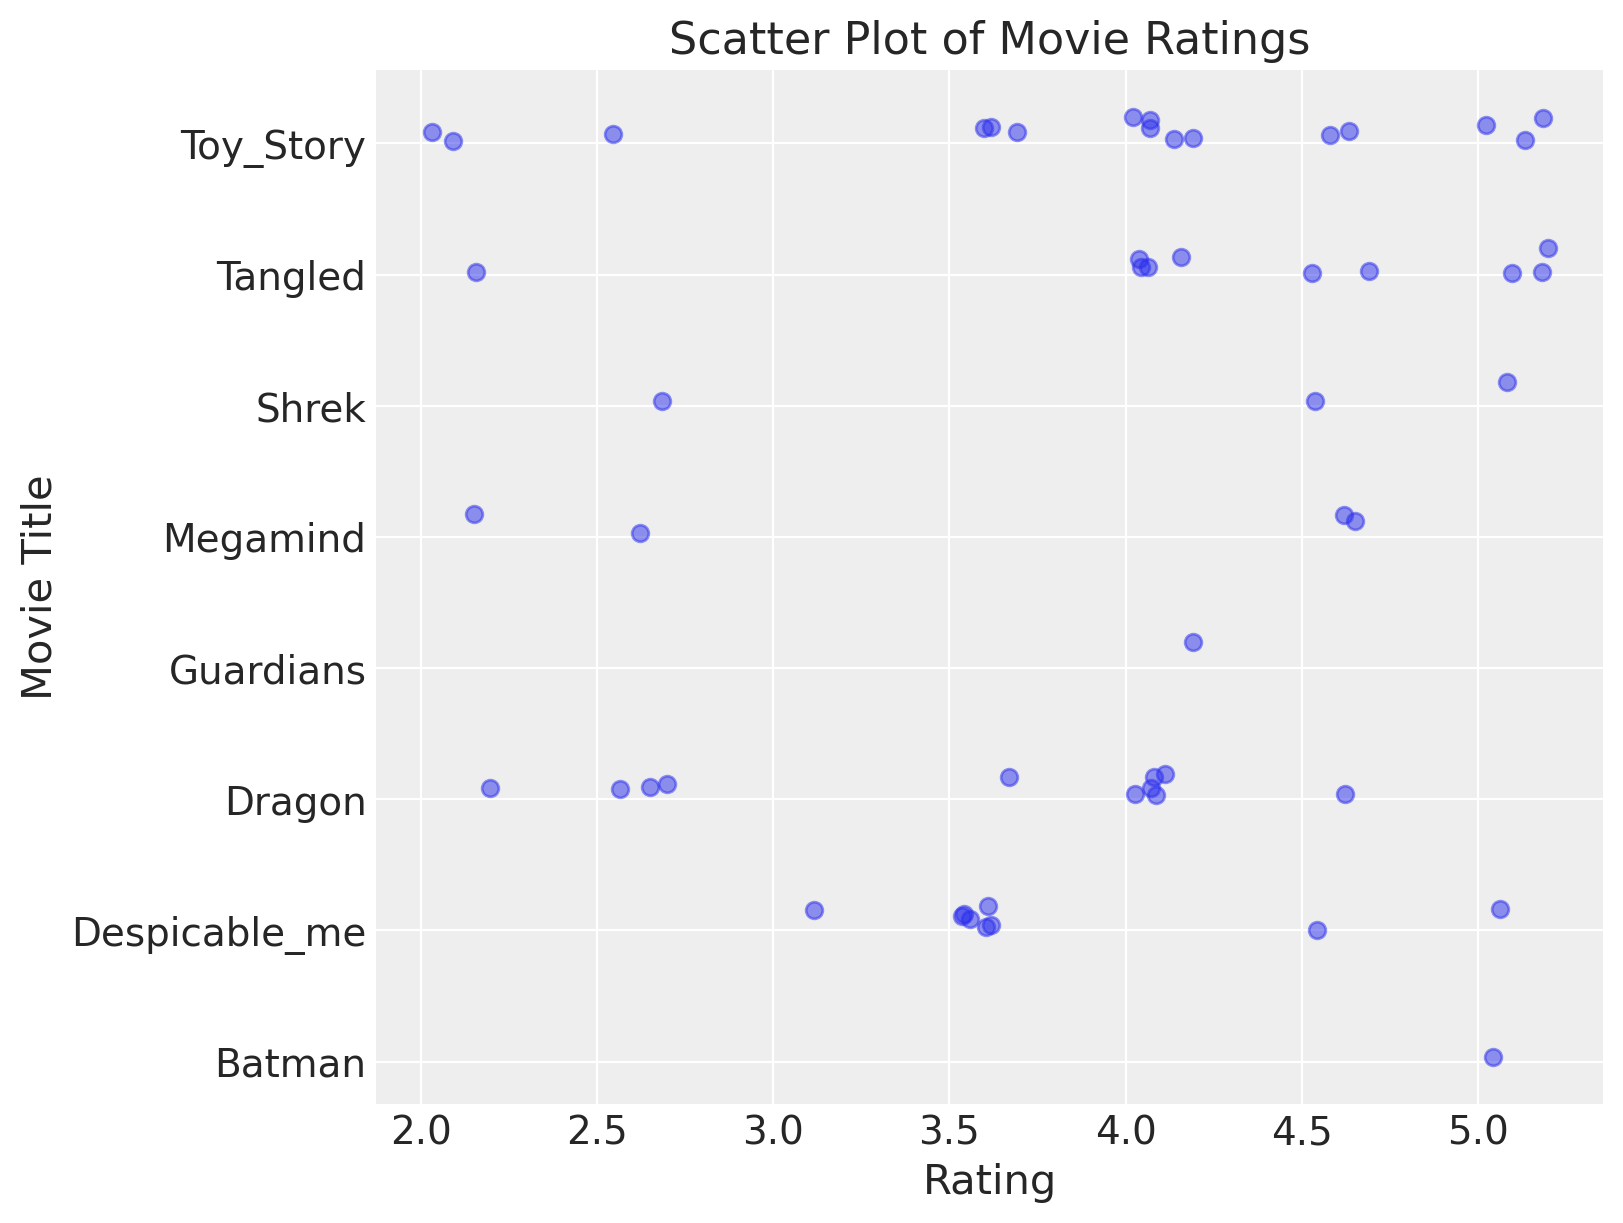

In [73]:
# Create a numeric category for movie titles
df['title_cat'] = pd.Categorical(df['title']).codes

# Generating jitter for the x-axis
x_jitter = 0.2 * np.random.rand(len(df))  # Adjust 0.1 to increase or decrease the jitter
y_jitter = 0.2 * np.random.rand(len(df))  # Jitter for y-axis, similar scale as x-axis

# Set up the plot
plt.figure(figsize=(8, 6))

# Creating the scatter plot
plt.scatter(df['rating'] + x_jitter, df['title_cat'] + y_jitter, alpha=0.5)

# Setting the x-axis to show movie titles instead of numbers
plt.yticks(df['title_cat'].unique(), df['title'].unique(), rotation=0)

plt.title('Scatter Plot of Movie Ratings')
plt.ylabel('Movie Title')
plt.xlabel('Rating')

# Show the plot
#plt.tight_layout()  # Adjust layout to make sure labels are readable
plt.show()

In [74]:
# Group by 'title' and aggregate the data
summary_df = df.groupby('title')['rating'].agg(['mean', 'std', 'count'])
summary_df

,mean,std,count
title,,,
Batman,5.000000,NaN,1
Despicable_me,3.722222,0.618017,9
Dragon,3.409091,0.860761,11
Guardians,4.000000,NaN,1
Megamind,3.375000,1.314978,4
Shrek,4.000000,1.322876,3
Tangled,4.200000,0.888194,10
Toy_Story,3.812500,0.963933,16


## Build simplest model

In [75]:
from pymc import Model, Normal, Gamma, Deterministic, sample, HalfNormal, InverseGamma

with Model() as simplest_model:
    # Define the priors
    mu = Normal("mu", mu=3, sigma=1)
    sigma = InverseGamma('sigma', alpha=3, beta=1)

    # Define likelihood
    obs = {}
    for i, title in enumerate(titles):
        obs[title] = Normal(f'obs_{title}', mu=mu, sigma=sigma, observed=title_to_ratings[title])

    # Inference!
    idata_simplest_model = sample(3000, return_inferencedata=True, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


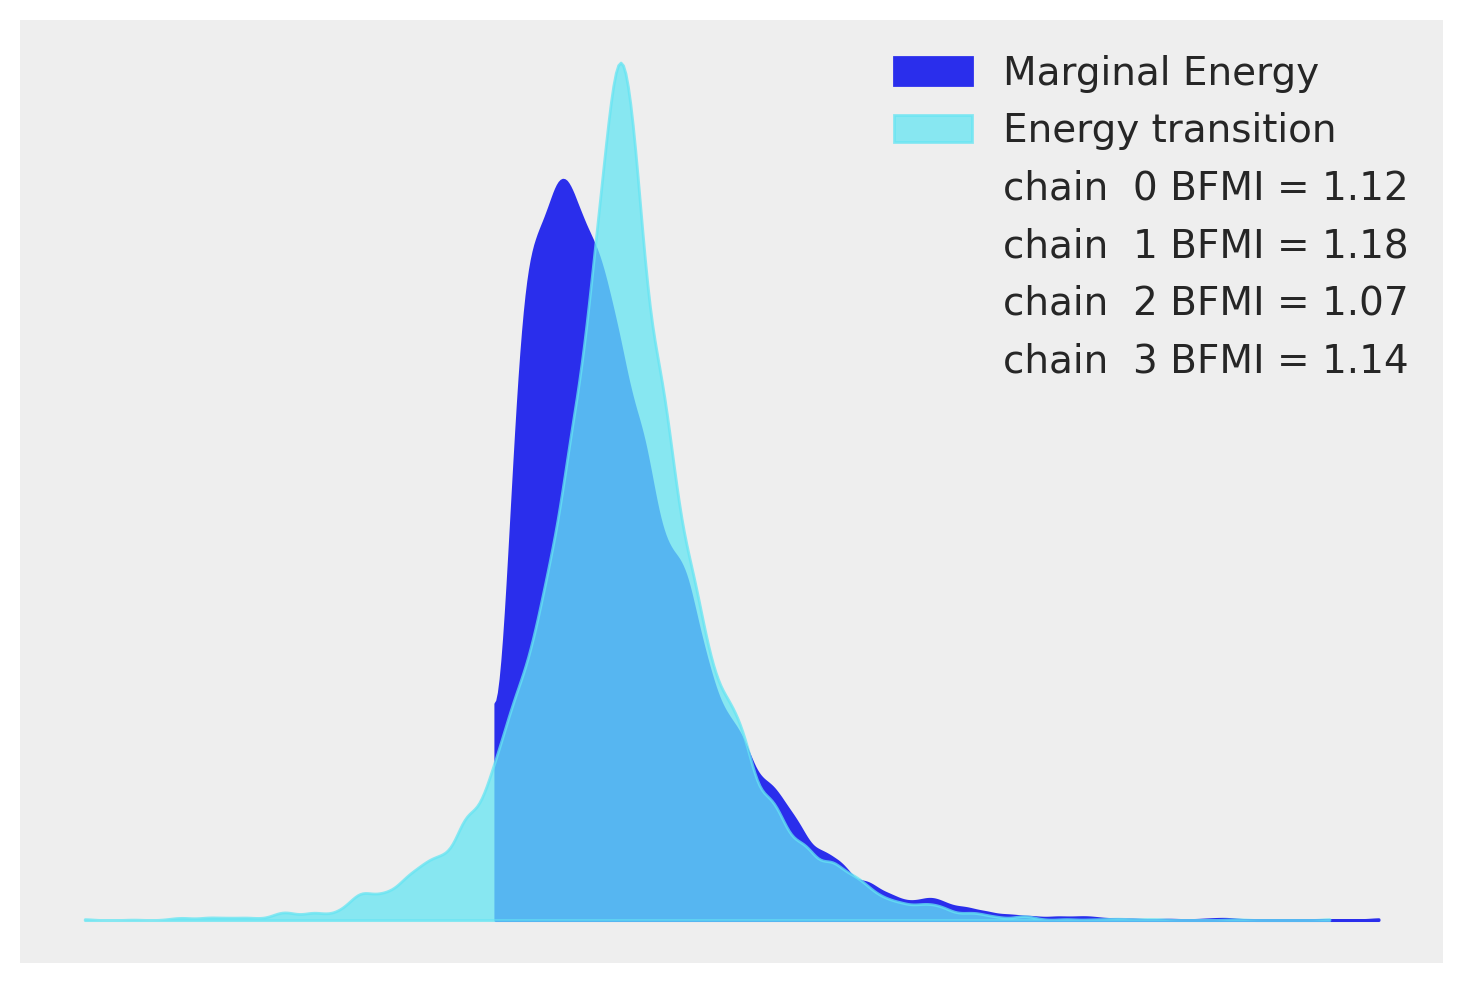

In [76]:
az.plot_energy(idata_simplest_model);

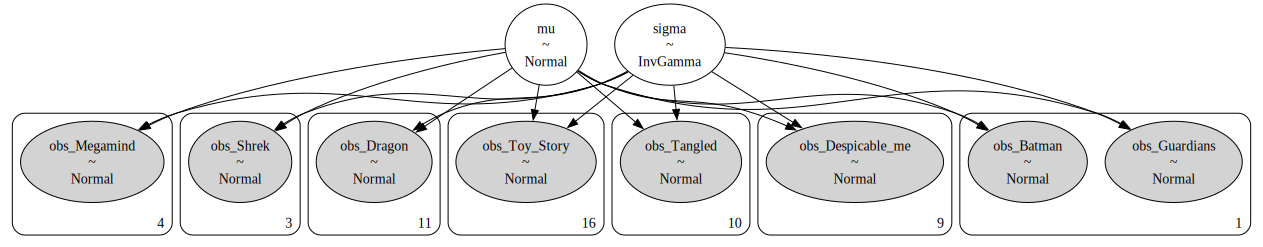

In [107]:
pm.model_to_graphviz(simplest_model)

In [77]:
with simplest_model:
    prior_check_simplest_model = pm.sample_prior_predictive(samples=1000)

Sampling: [mu, obs_Batman, obs_Despicable_me, obs_Dragon, obs_Guardians, obs_Megamind, obs_Shrek, obs_Tangled, obs_Toy_Story, sigma]


In [82]:
# Dictionary to hold samples for each movie
samples_dict_simplest_model = {}

for title in titles:
    key = f"obs_{title.replace(' ', '_')}"  # Replace spaces with underscores if needed
    # Extract and flatten samples, store in dictionary
    samples_dict_simplest_model[title] = prior_check_simplest_model.prior_predictive[key].values.flatten()

/var/folders/3v/qbgbs1s16ds_0dymg_tpg8040000gn/T/ipykernel_10015/1574116987.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


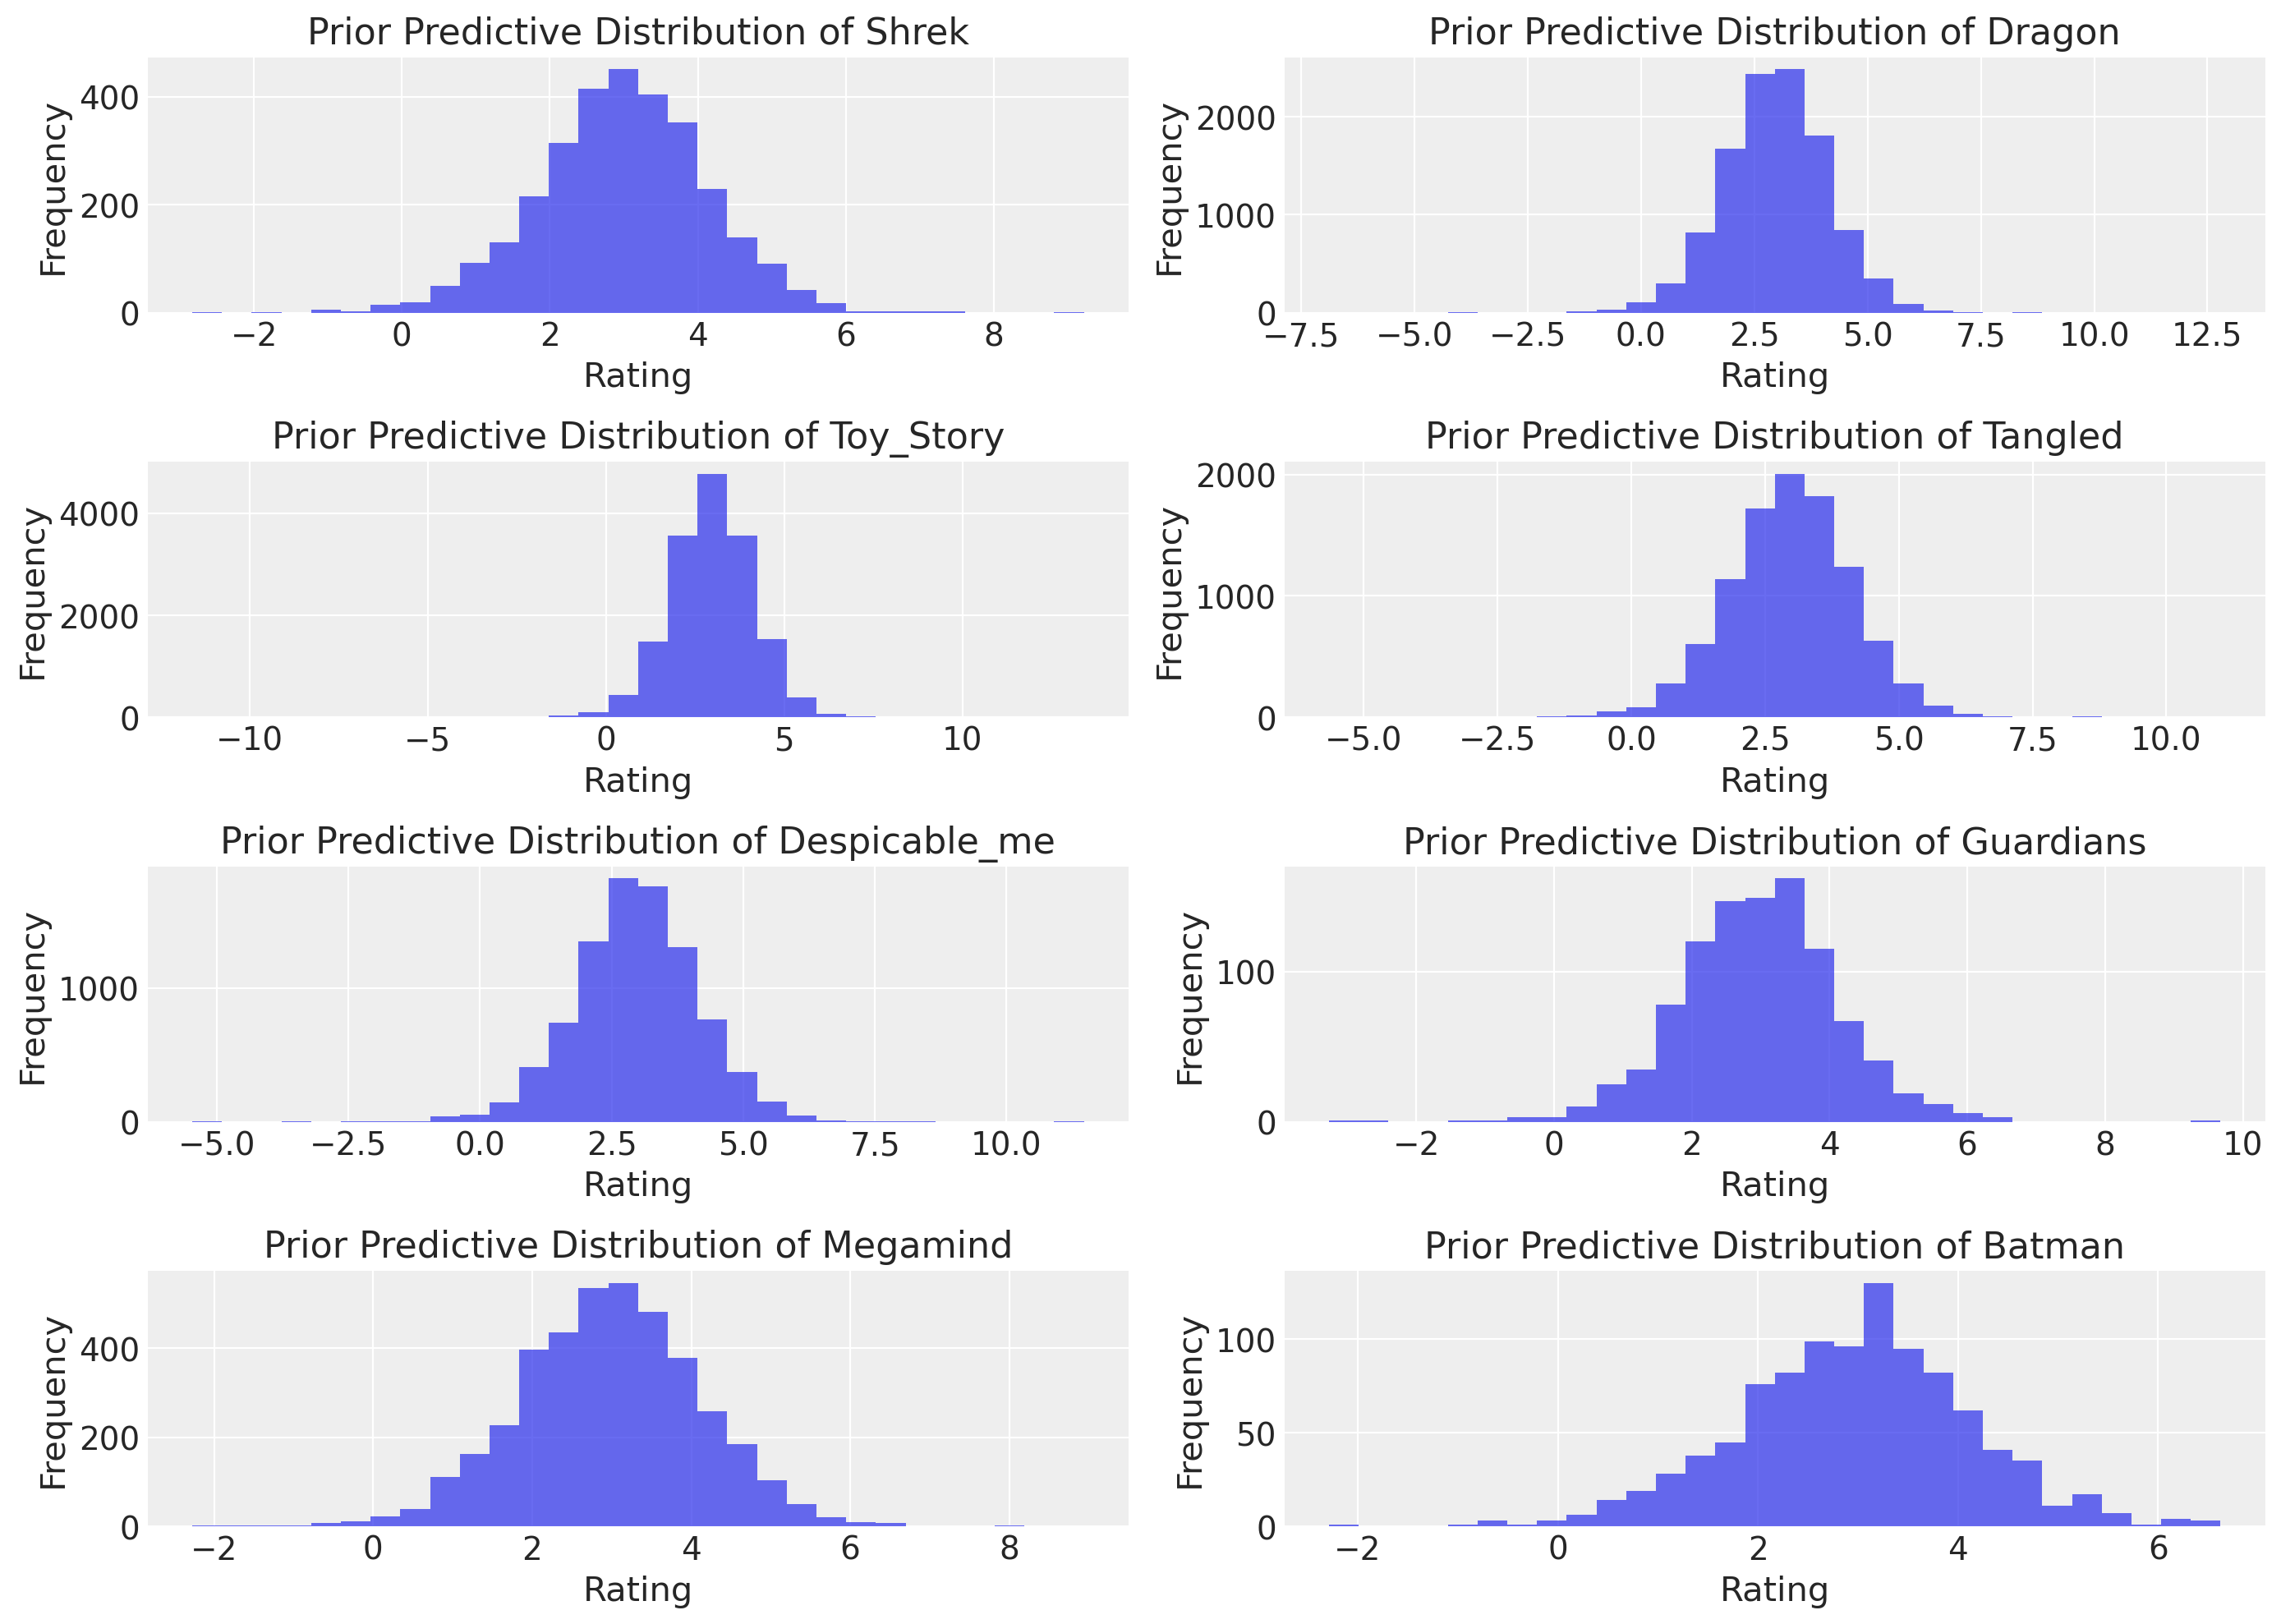

In [83]:
# Prepare the figure layout
plt.figure(figsize=(14, 10))  # Adjust the size as necessary

for i, title in enumerate(titles, 1):
    plt.subplot(4, 2, i)  # Adjust the grid dimensions based on the number of movies
    plt.hist(samples_dict_simplest_model[title], bins=30, alpha=0.7)  # Use the samples from the dictionary
    plt.title(f'Prior Predictive Distribution of {title}')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [85]:
# Check the trace summary for results
summary = pm.summary(idata_simplest_model)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3.780,0.123,3.556,4.016,0.001,0.001,10974.0,6926.0,1.0
sigma,0.916,0.087,0.762,1.088,0.001,0.001,8755.0,6871.0,1.0


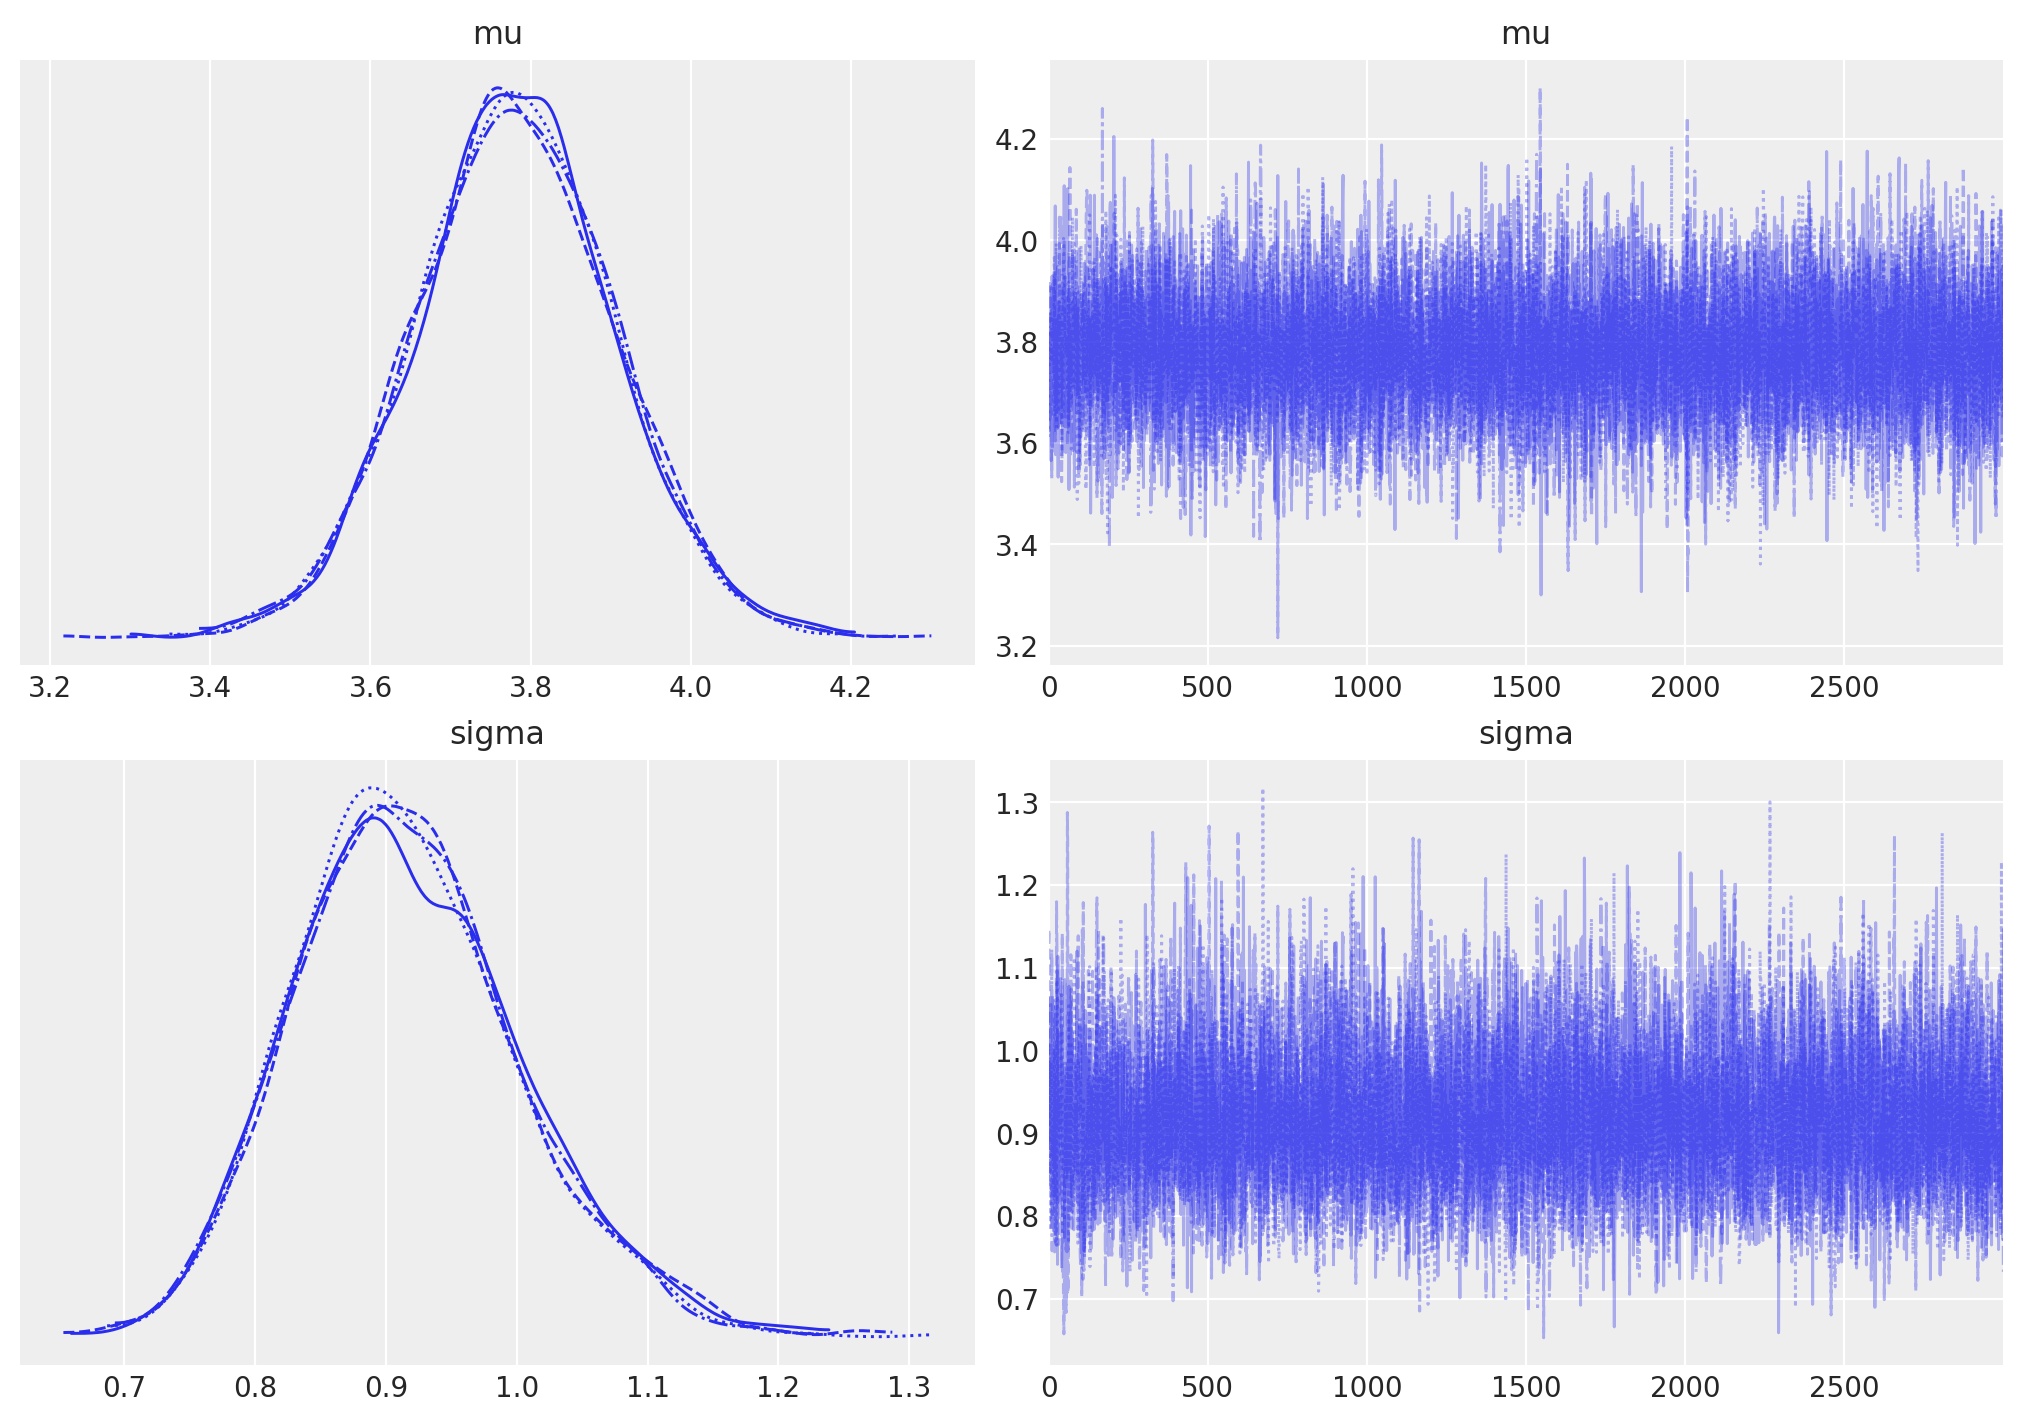

In [86]:
az.plot_trace(idata_simplest_model, var_names=['mu', 'sigma'], figsize=(10, 7));

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

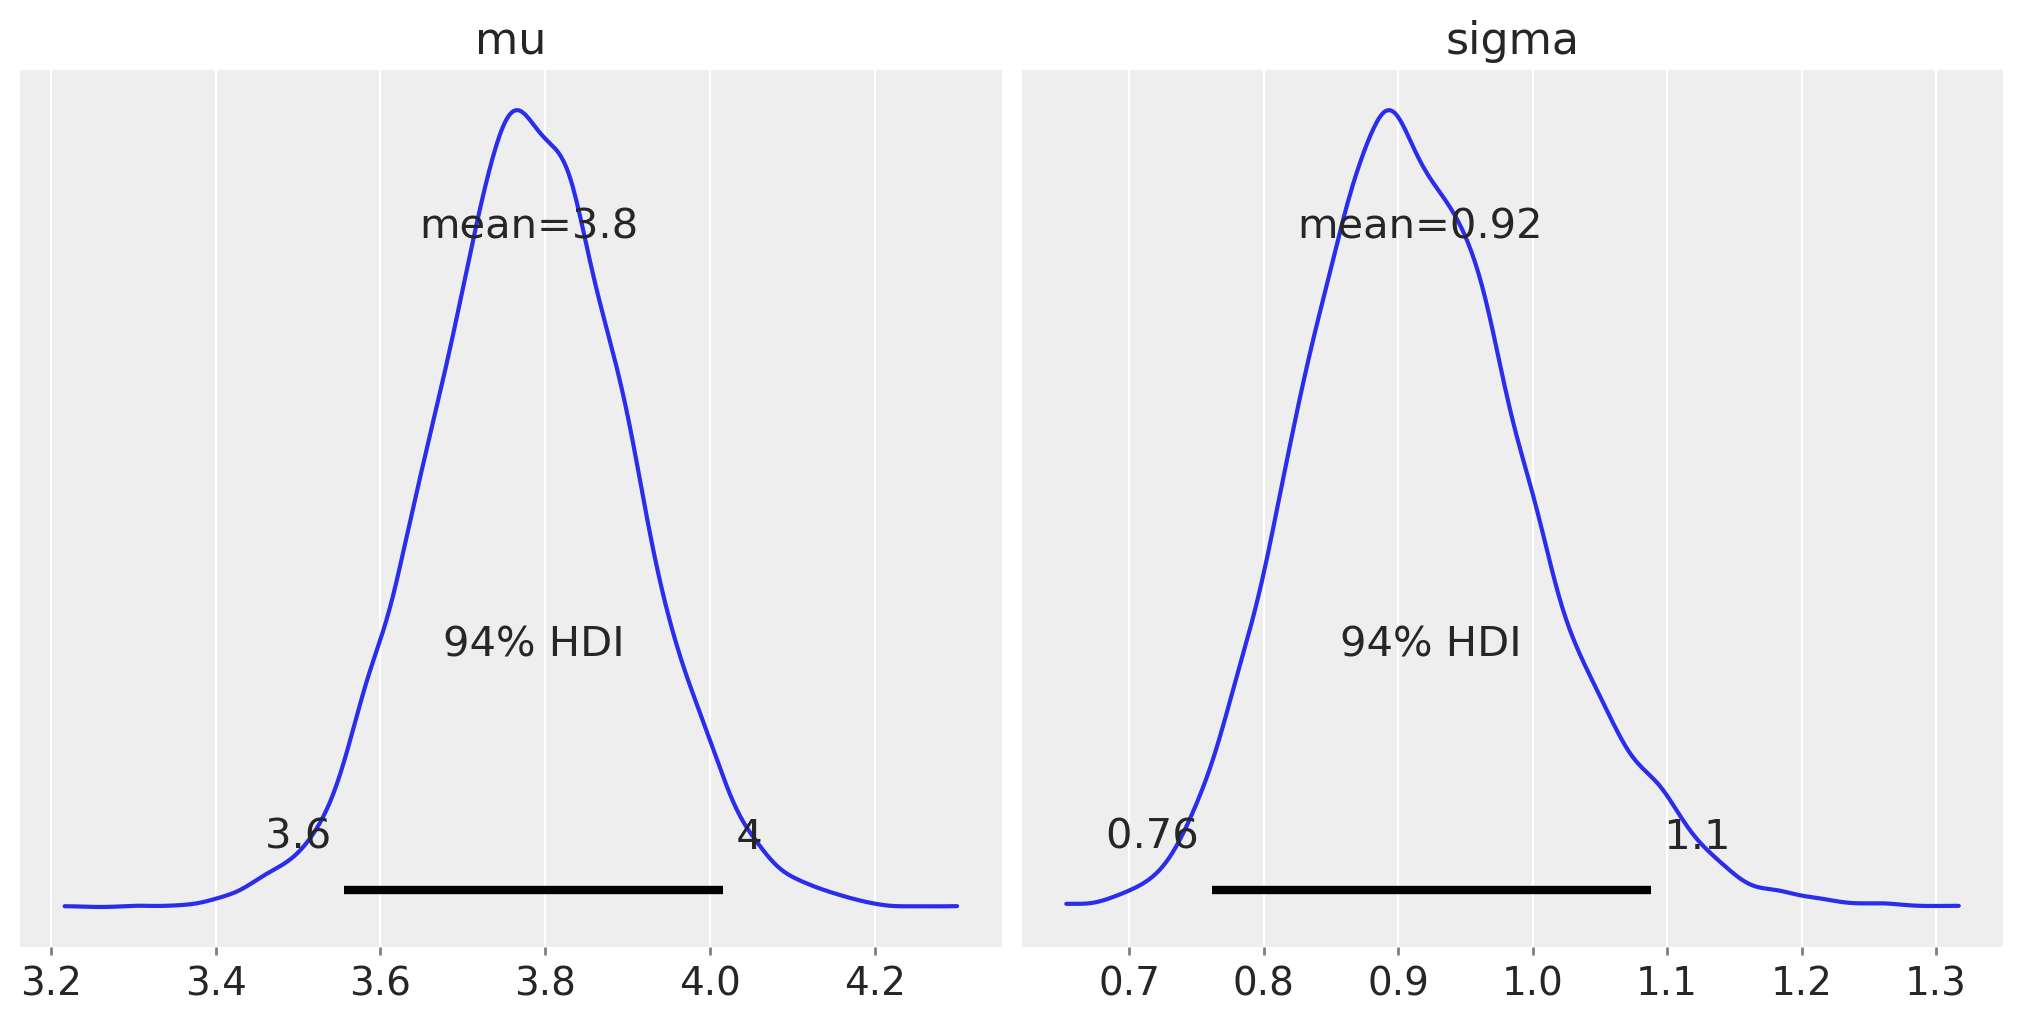

In [87]:
# Plot posterior with HDI
az.plot_posterior(idata_simplest_model, var_names=['mu', 'sigma'], figsize=(10, 5), hdi_prob=0.94)

In [121]:
with simplest_model:
    posterior_predictive = pm.sample_posterior_predictive(idata_simplest_model)

Sampling: [obs_Batman, obs_Despicable_me, obs_Dragon, obs_Guardians, obs_Megamind, obs_Shrek, obs_Tangled, obs_Toy_Story]


In [ ]:
b

## Build the Normal Hierarchical Model

In [111]:
from pymc import Model, Normal, Gamma, Deterministic, sample, HalfNormal, InverseGamma

with Model() as simple_normal_model:
    # Define Stage 2 priors - Hyperprior
    mu_hyperprior = Normal("mu_hyperprior", mu=3, sigma=1)
    sigma_hyperprior = InverseGamma('sigma_hyperprior', alpha=4, beta=1)

    # Define Stage 1 priors
    mu_i = Normal("mu_i", mu=mu_hyperprior, sigma=sigma_hyperprior, shape=len(titles))
    sigma =  InverseGamma('sigma', alpha=1, beta=1)

    # Define likelihood
    obs = {}
    for i, title in enumerate(titles):
        obs[title] = Normal(f'obs_{title}', mu=mu_i[i], sigma=sigma, observed=title_to_ratings[title])

    # Inference!
    idata_simple_normal_model = sample(3000, return_inferencedata=True, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_hyperprior, sigma_hyperprior, mu_i, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


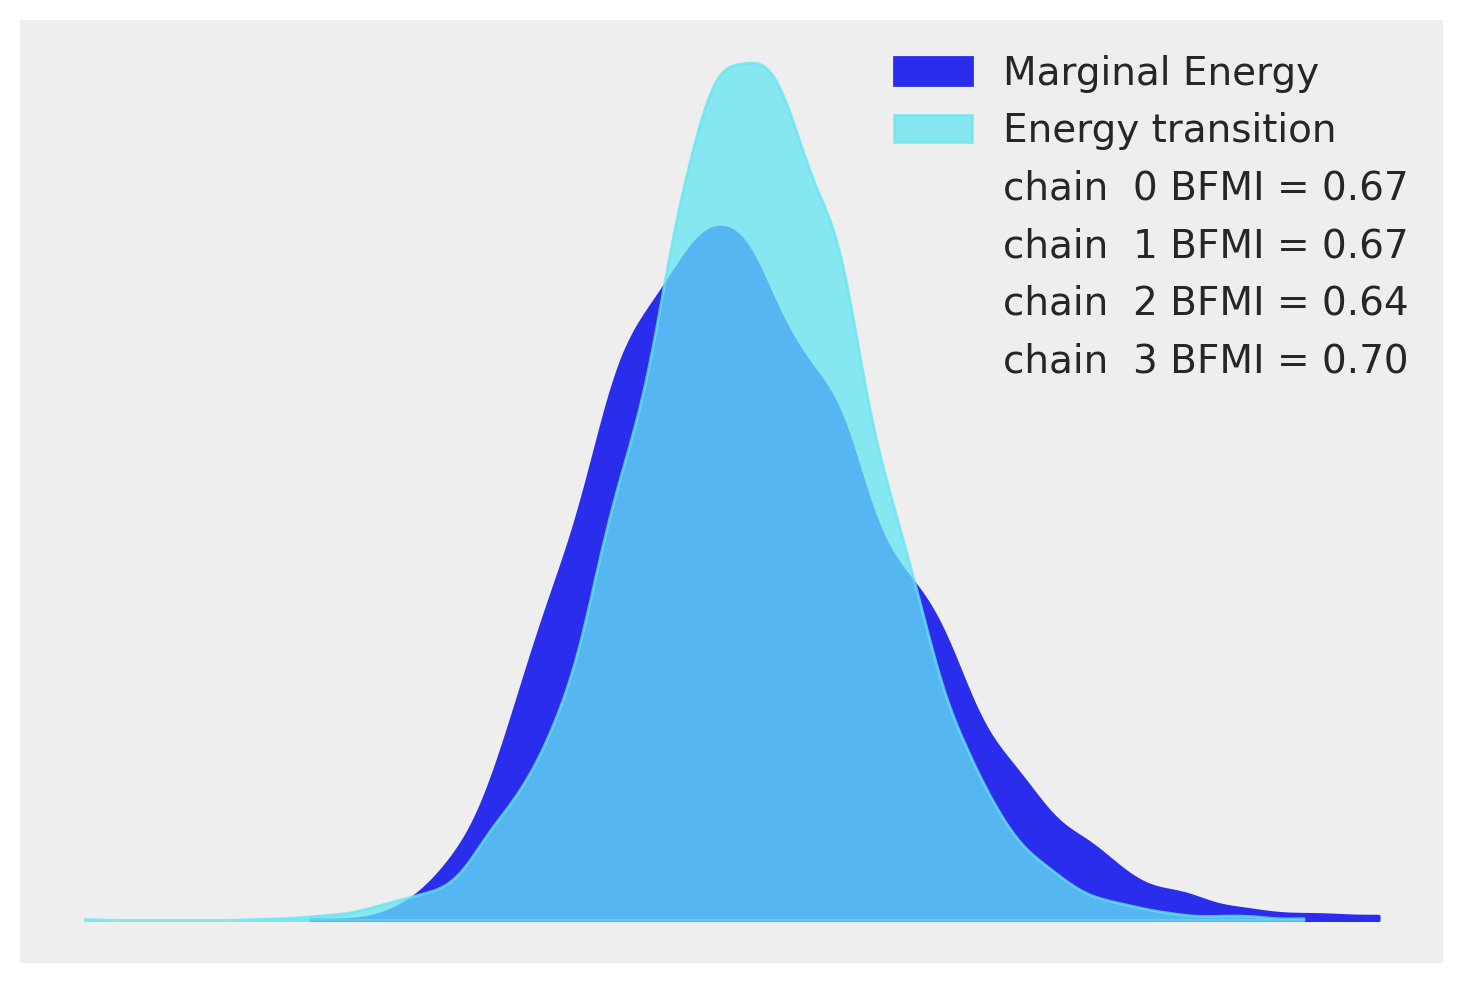

In [112]:
az.plot_energy(idata_simple_normal_model);

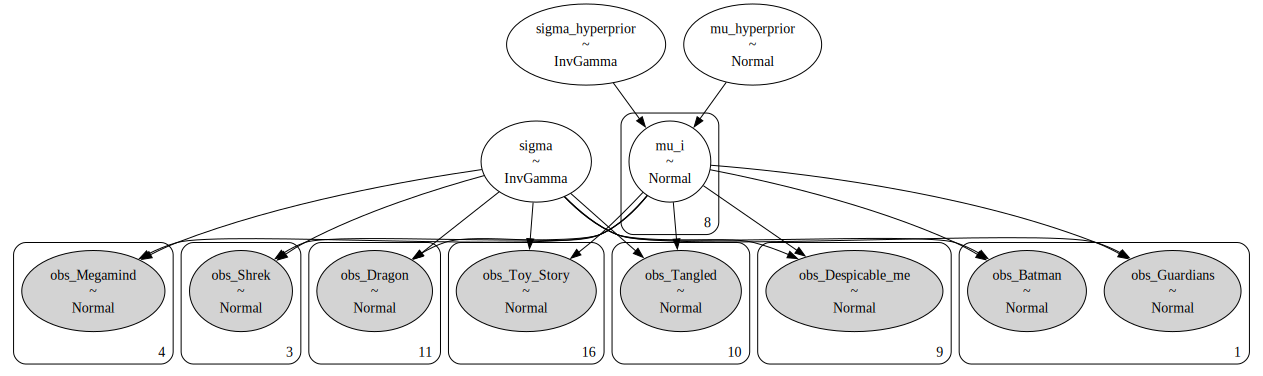

In [113]:
pm.model_to_graphviz(simple_normal_model)

In [114]:
with simple_normal_model:
    prior_check_simple_normal_model = pm.sample_prior_predictive(samples=1000)

Sampling: [mu_hyperprior, mu_i, obs_Batman, obs_Despicable_me, obs_Dragon, obs_Guardians, obs_Megamind, obs_Shrek, obs_Tangled, obs_Toy_Story, sigma, sigma_hyperprior]


In [115]:
# Dictionary to hold samples for each movie
samples_dict_simple_normal_model = {}

for title in titles:
    key = f"obs_{title.replace(' ', '_')}"  # Replace spaces with underscores if needed
    # Extract and flatten samples, store in dictionary
    samples_dict_simple_normal_model[title] = prior_check_simple_normal_model.prior_predictive[key].values.flatten()

/var/folders/3v/qbgbs1s16ds_0dymg_tpg8040000gn/T/ipykernel_10015/1597832371.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


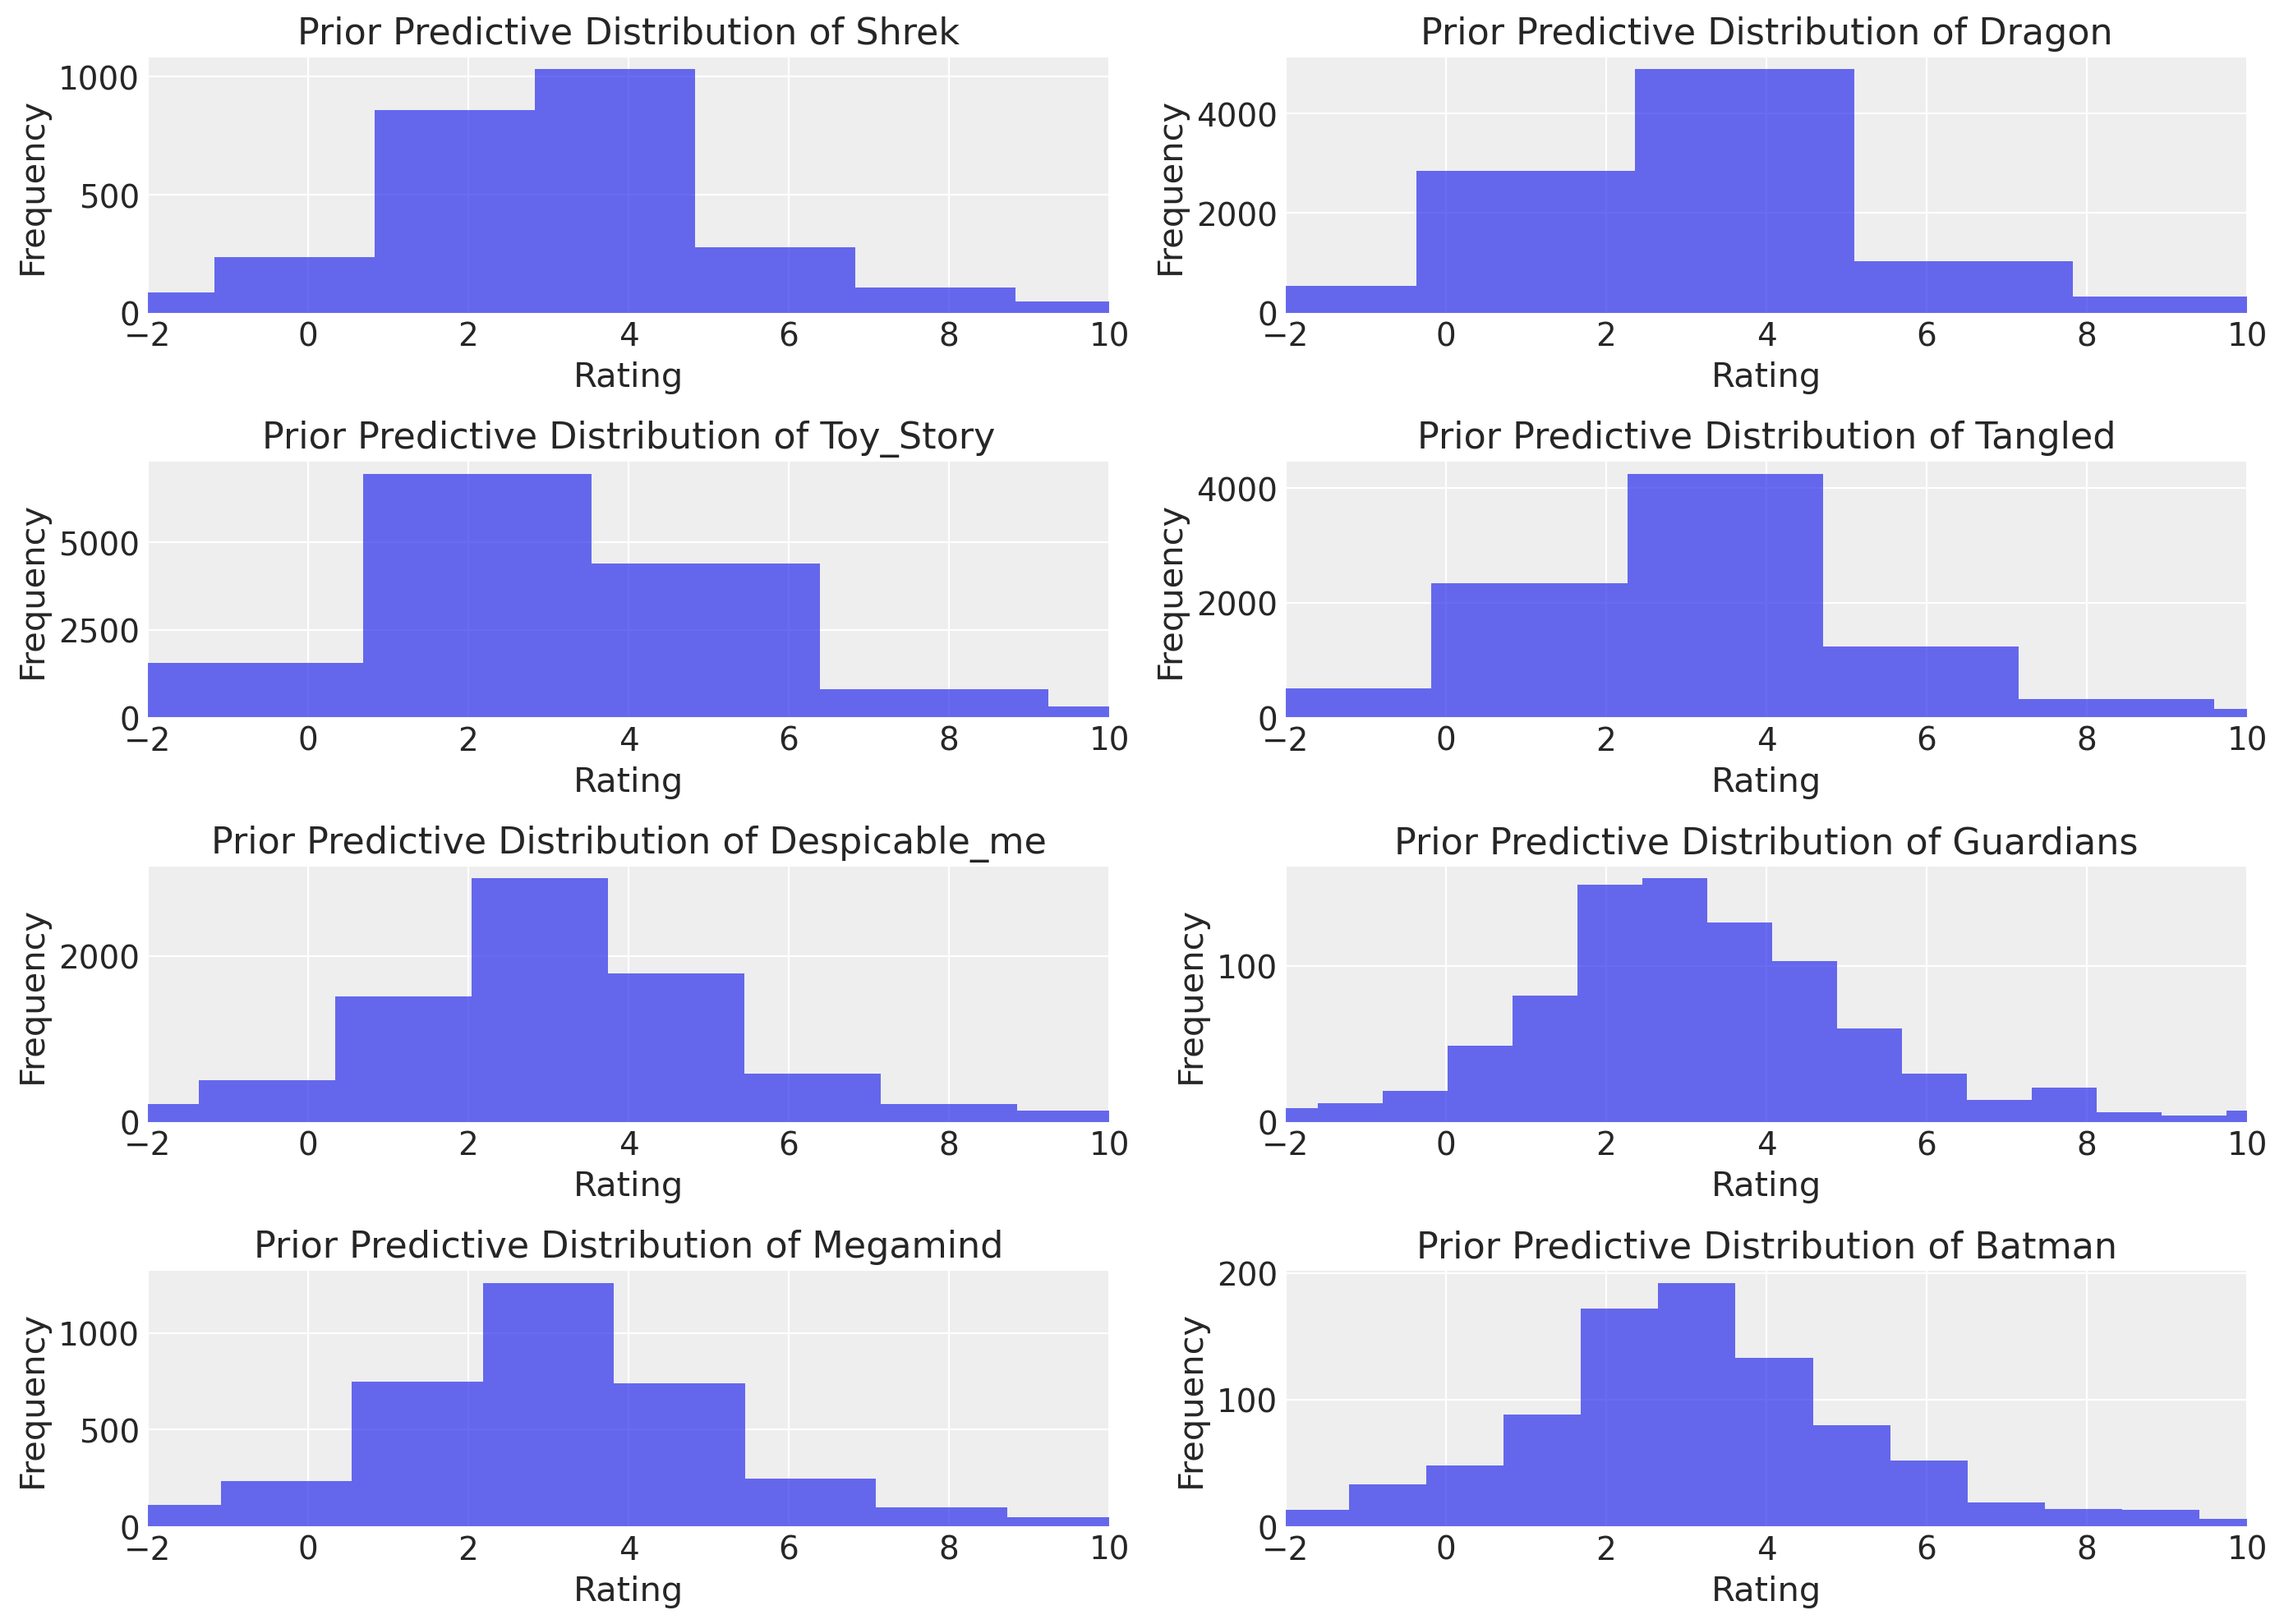

In [103]:
# Prepare the figure layout
plt.figure(figsize=(14, 10))  # Adjust the size as necessary

for i, title in enumerate(titles, 1):
    plt.subplot(4, 2, i)  # Adjust the grid dimensions based on the number of movies
    plt.hist(samples_dict_simple_normal_model[title], bins=3000, alpha=0.7)  # Use the samples from the dictionary
    plt.title(f'Prior Predictive Distribution of {title}')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.xlim(-2,10)

plt.tight_layout()
plt.show()

In [116]:
# Check the trace summary for results
summary = pm.summary(idata_simple_normal_model)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_hyperprior,3.782,0.167,3.488,4.120,0.002,0.002,4819.0,6387.0,1.0
mu_i[0],3.823,0.267,3.302,4.316,0.003,0.002,7462.0,7671.0,1.0
mu_i[1],3.627,0.215,3.217,4.026,0.003,0.002,6374.0,7296.0,1.0
mu_i[2],3.797,0.181,3.467,4.149,0.002,0.002,7231.0,8033.0,1.0
mu_i[3],3.948,0.219,3.547,4.373,0.003,0.002,6556.0,7778.0,1.0
mu_i[4],3.761,0.209,3.354,4.144,0.002,0.002,7823.0,7997.0,1.0
mu_i[5],3.801,0.297,3.231,4.368,0.003,0.002,7736.0,7849.0,1.0
mu_i[6],3.693,0.261,3.198,4.182,0.003,0.002,7427.0,7578.0,1.0
mu_i[7],3.876,0.304,3.301,4.458,0.004,0.003,7615.0,7219.0,1.0
sigma,0.925,0.092,0.763,1.100,0.001,0.001,9835.0,7627.0,1.0


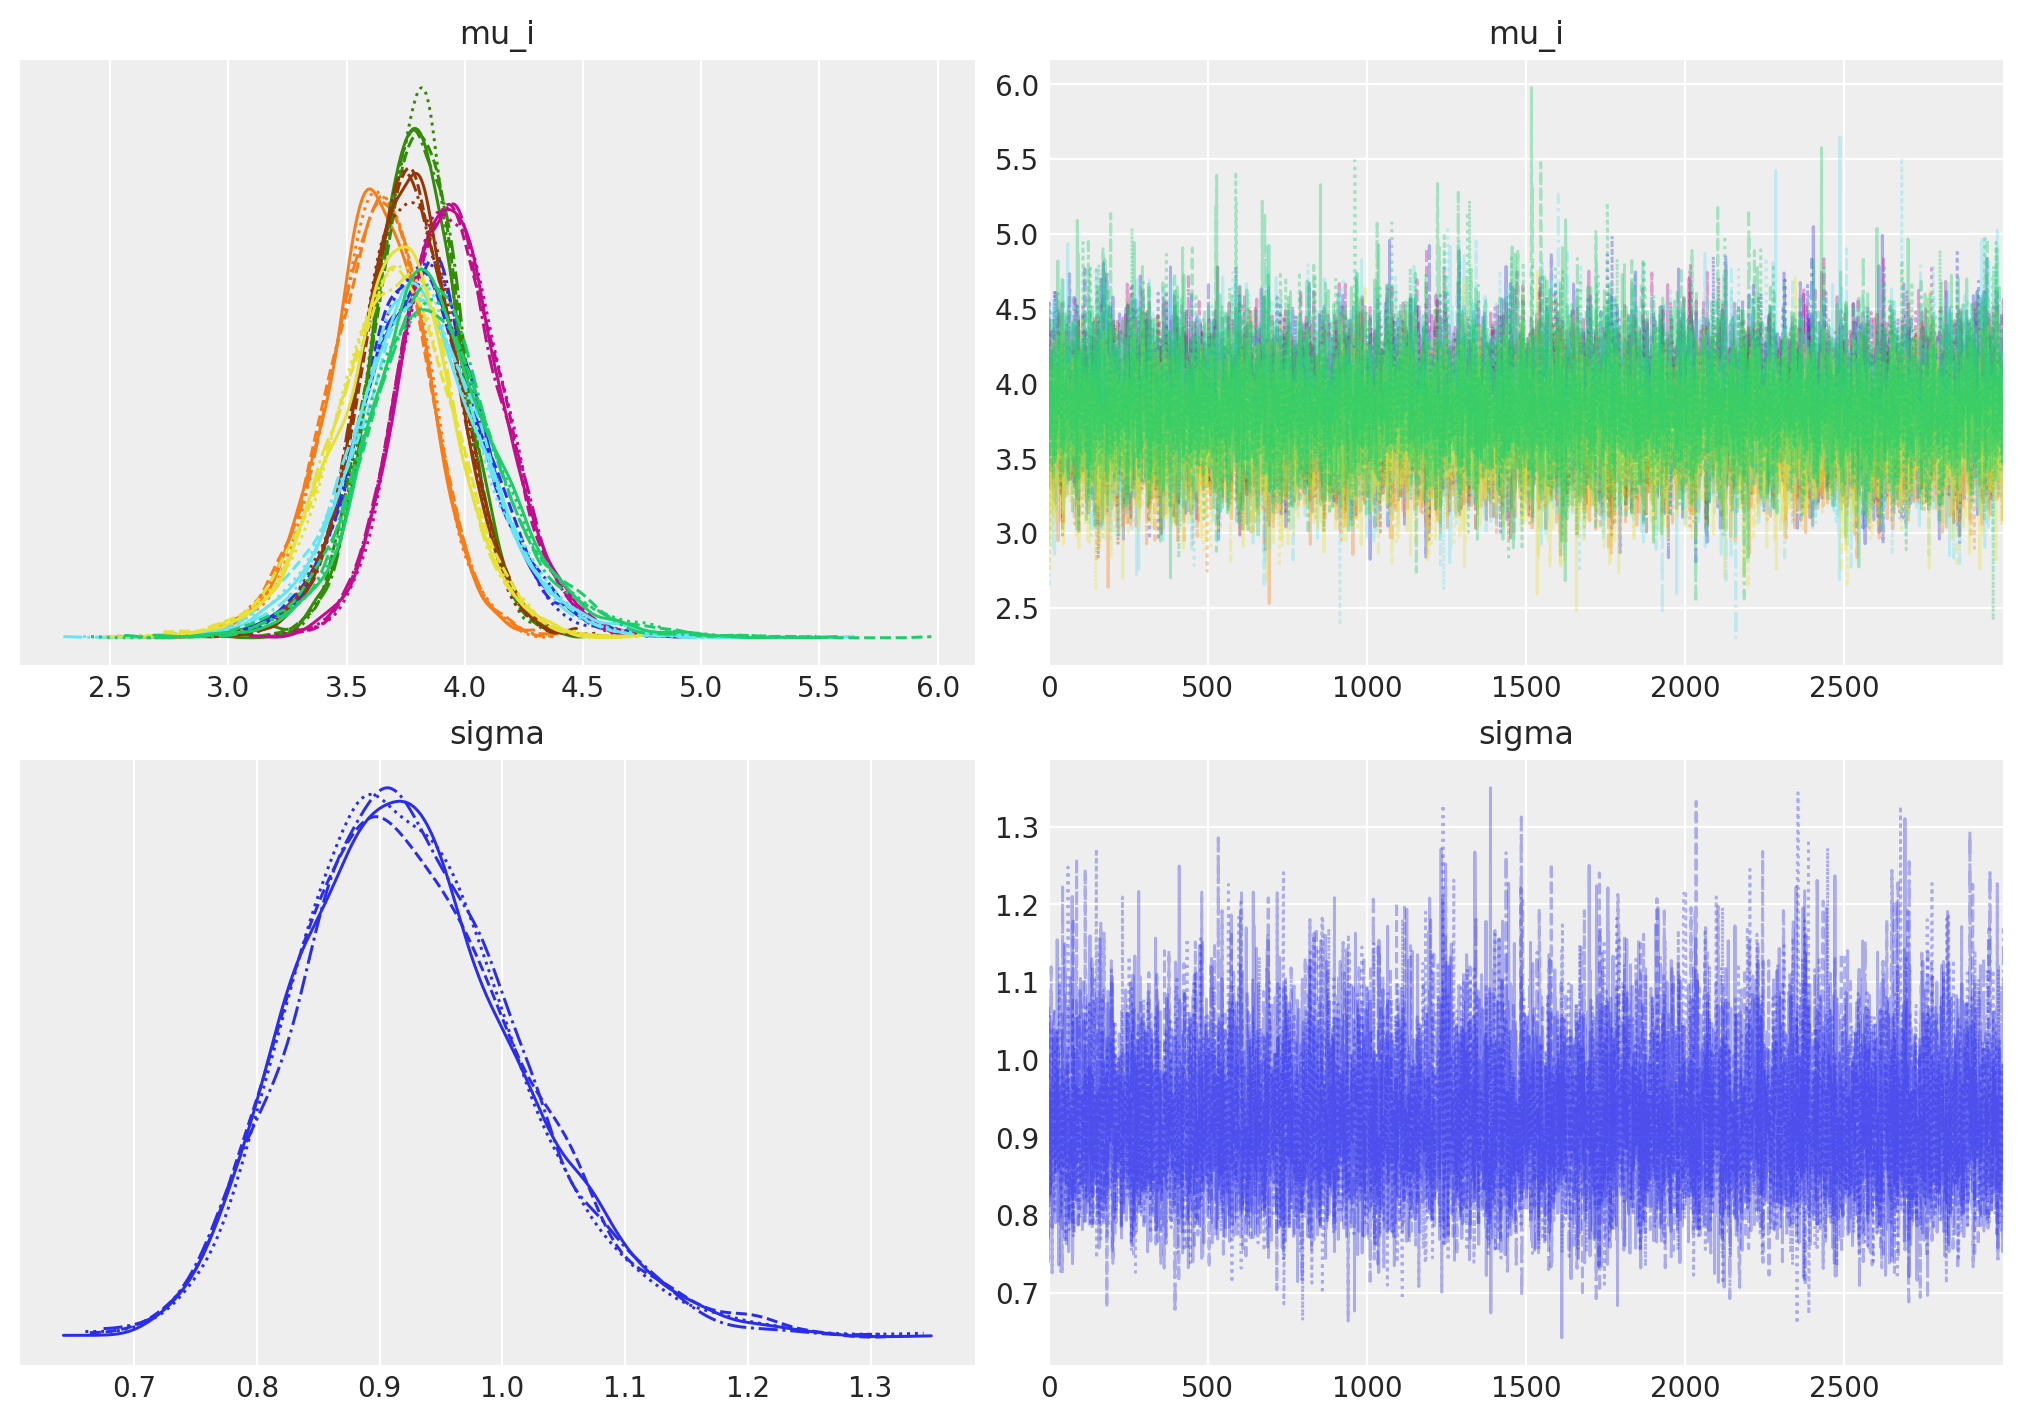

In [117]:
az.plot_trace(idata_simple_normal_model, var_names=['mu_i', 'sigma'], figsize=(10, 7));

array([[<Axes: title={'center': 'mu_i\n0'}>,
        <Axes: title={'center': 'mu_i\n1'}>,
        <Axes: title={'center': 'mu_i\n2'}>],
       [<Axes: title={'center': 'mu_i\n3'}>,
        <Axes: title={'center': 'mu_i\n4'}>,
        <Axes: title={'center': 'mu_i\n5'}>],
       [<Axes: title={'center': 'mu_i\n6'}>,
        <Axes: title={'center': 'mu_i\n7'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

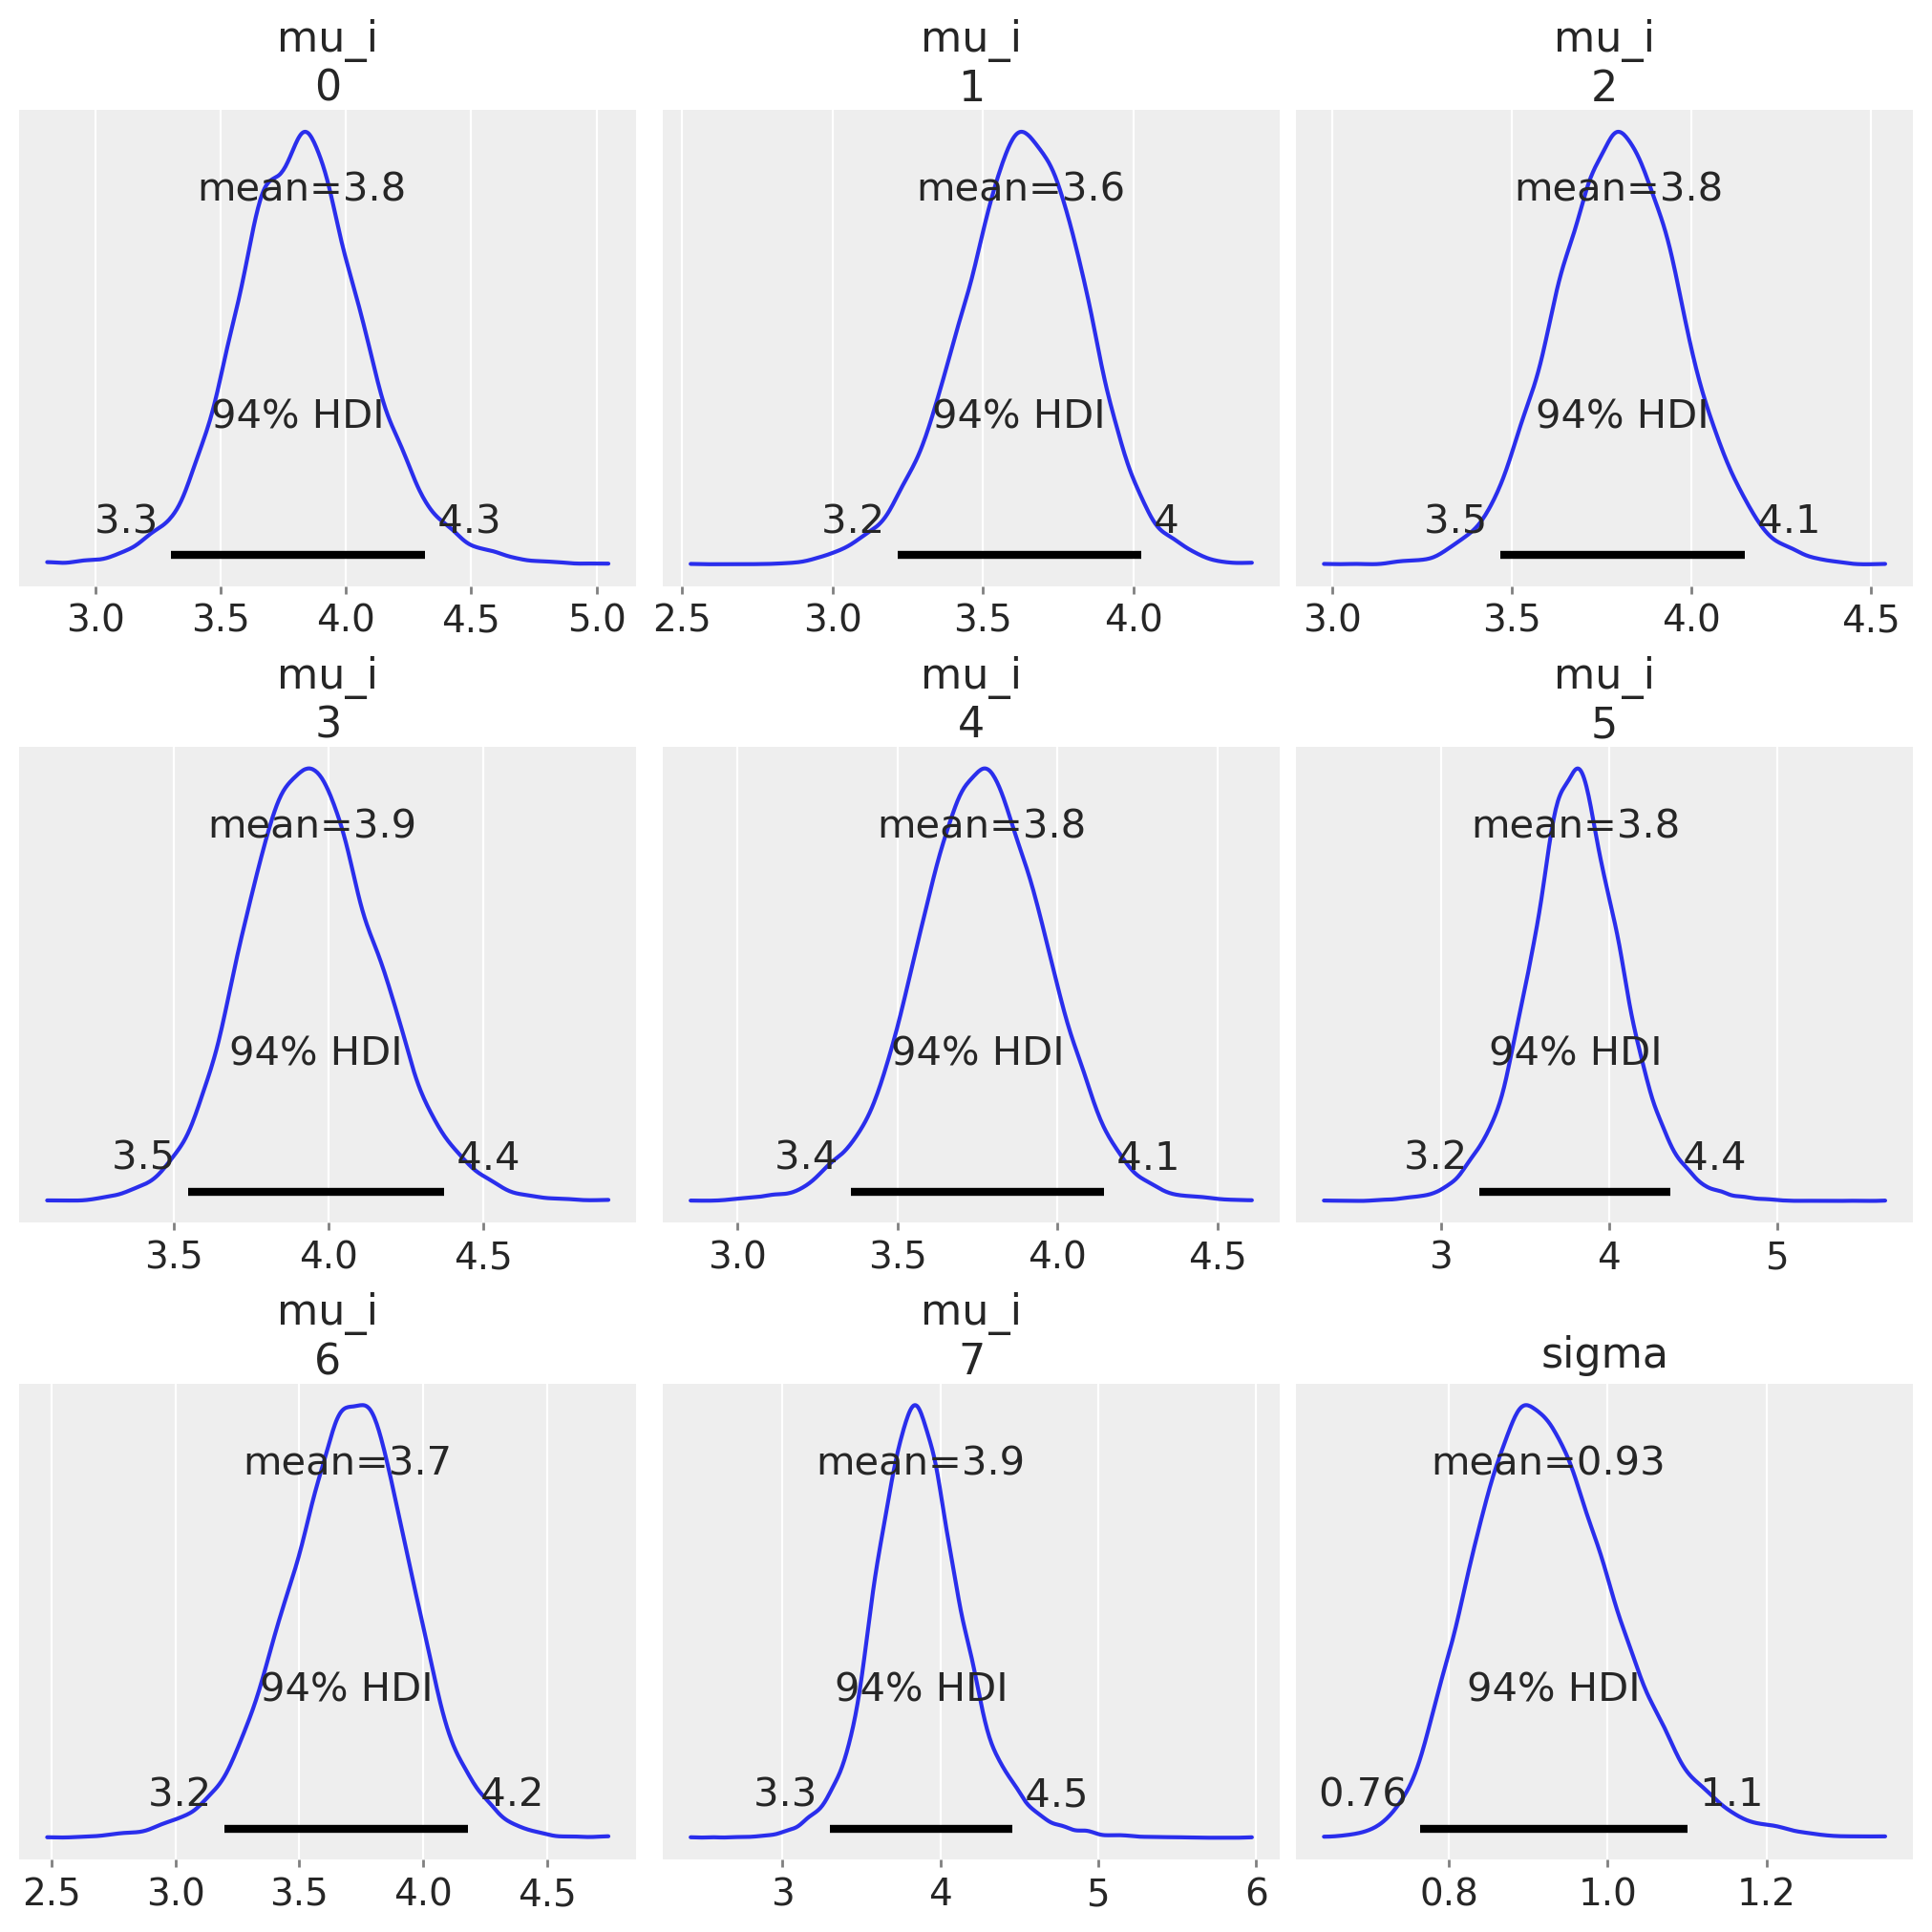

In [119]:
# Plot posterior with HDI
az.plot_posterior(idata_simple_normal_model, var_names=['mu_i', 'sigma'], figsize=(10, 10), hdi_prob=0.94)